## How to Use EvalxNLP Framework for Sentiment Analysis – A Beginner-Friendly Guide 🚀

#### What is EvalxNLP?

Imagine you have a sentiment analysis model that predicts whether a sentence is positive, neutral, or negative. But how does it know what makes a sentence negative? Does it focus on the right words?

That’s where EvalxNLP helps! 🦊

✅ EvalxNLP explains model predictions by showing which words had the most impact.

✅ Helps you trust the model’s decisions.

✅ Useful for debugging why your model makes mistakes.

In [ ]:
import sys
sys.path.append('..')
from XAIbenchmark import XAIFramework
import warnings

warnings.filterwarnings("ignore")

d:\EvalxNLP\venv32\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
%load_ext autoreload
%autoreload 2

#### Single Sentence

Step 1: Load a pre-trained Sentiment Model, and Tokenizer

In [32]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Step 2: Optionally initialize the explainers, and evaluators

In [4]:
import torch
from explainers import InputXGradientExplainer, IntegratedGradientsExplainer, DeepLiftExplainer, LimeExplainer, SHAPExplainer, SHAPIQExplainer, GuidedBackpropExplainer
device = "cuda" if torch.cuda.is_available() else "cpu"
ig= IntegratedGradientsExplainer(model,tokenizer,device)
gb= GuidedBackpropExplainer(model,tokenizer,device)
dl= DeepLiftExplainer(model,tokenizer,device)
ixg= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=True)
g= InputXGradientExplainer(model,tokenizer,device,multiply_by_inputs=False)
lime= LimeExplainer(model,tokenizer)
shap= SHAPExplainer(model,tokenizer)
shapiq= SHAPIQExplainer(model,tokenizer)

In [5]:
from evaluators import AUCTPEvaluator, SoftComprehensivenessEvaluator, SoftSufficiencyEvaluator, FADEvaluator, SparsenessEvaluator, ComplexityEvaluator, IOUF1Evaluator,TokenF1Evaluator, AUPRCEvaluator

sc= SoftComprehensivenessEvaluator(model,tokenizer,device)
ss= SoftSufficiencyEvaluator(model,tokenizer,device)
fad= FADEvaluator(model,tokenizer,device)
sp= SparsenessEvaluator(model,tokenizer,device)
cx= ComplexityEvaluator(model,tokenizer,device)
auctp= AUCTPEvaluator(model,tokenizer,device)
iou_f1= IOUF1Evaluator(model,tokenizer,device)
token_f1= TokenF1Evaluator(model,tokenizer,device)
auprc= AUPRCEvaluator(model,tokenizer,device)

Step 3: Inialize XAIBenchmark Class

In [6]:
xai_framework = XAIFramework(model, tokenizer,explainers=[g], evaluators=[cx,sc,ss,fad,sp,auctp],device=device)

> **Note:** If you don’t pass any explainers or evaluators, it defaults to all explainers/evaluators.

Step 4: Predict Sentiment of a Sentence

In [ ]:
#Define the senece to be explained
# sentence= "Great movie for a great nap!"
# sentence= "Worst experience I've ever had!"
sentence= "A masterpiece of how not to make a movie."
xai_framework.classify_text(sentence)

{'negative': 0.07390535622835159,
 'neutral': 0.10088995099067688,
 'positive': 0.8252046704292297}

Step 5: Use EvalxNLP to Explain Why

You can use the `XAIBenchmark` class to explain for all the explainers defined during the initiation of the `XAIBenchmark` class

In [8]:
exps= xai_framework.explain(input_data=sentence,target_label="positive")
exps

Explanation(
  text=['A masterpiece of how not to make a movie.'],
  tokens=['<s>', '▁A', '▁master', 'piece', '▁of', '▁how', '▁not', '▁to', '▁make', '▁a', '▁movie', '.', '</s>'],
  scores=[0.05983935 0.02848242 0.18051037 0.1956277  0.04314518 0.08561721
 0.11212566 0.04384509 0.06295516 0.0221678  0.0799308  0.02522218
 0.06053117],
  explainer=Saliency,
  target=positive,
)

Or you can use an individual explainer's `compute_feature_importance` method to get importance scores.

In [ ]:
ig_exps= ig.compute_feature_importance(sentence, target="positive")
gb_exps= gb.compute_feature_importance(sentence, target="positive")
dl_exps= dl.compute_feature_importance(sentence, target="positive")
ixg_exps= ixg.compute_feature_importance(sentence, target="positive")
lime_exps= lime.compute_feature_importance(sentence, target="positive")
shap_exps= shap.compute_feature_importance(sentence, target="positive")
shapiq_exps= shapiq.compute_feature_importance(sentence, target="positive")
g_exps= g.compute_feature_importance(sentence, target="positive")

Running Inference: 100%|██████████| 25/25 [00:10<00:00,  2.43it/s]


Step 5: Visualize the Explanation

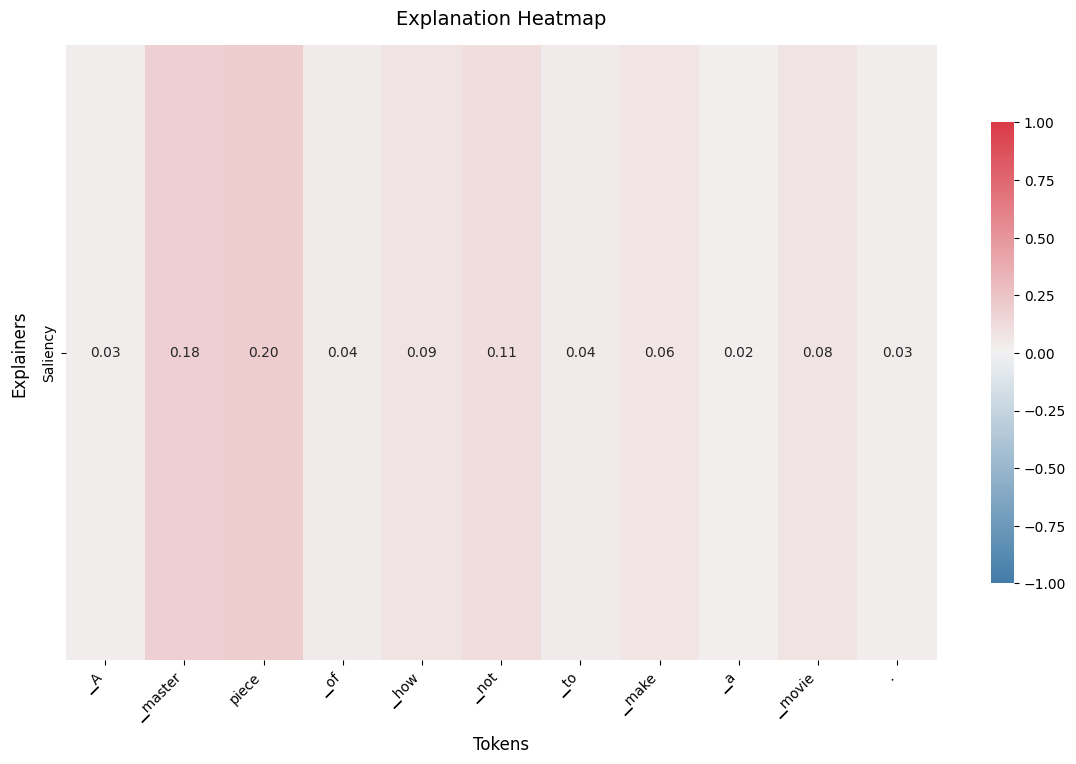

In [10]:
xai_framework.visualize(exps)

In [11]:
from LLMExplanationGenerator import LLMExplanationGenerator
import pandas as pd
from IPython.display import display, HTML

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = LLMExplanationGenerator(api_key=api_key)

# Generate and save explanations (returns both explanations and file paths)
explanations, saved_files = explainer.generate_and_save_explanations(
    exps=exps,
    output_format="both"  # or "json"/"html"
)

# Display in notebook
explainer.display_explanations(explanations)

# Print saved locations
print(f"Saved files: {[str(p) for p in saved_files]}")


file saved in ..\results\llm_explanations\explanations.html


Saved files: ['..\\results\\llm_explanations\\explanations.json', '..\\results\\llm_explanations\\explanations.html']


📌 How to Interpret EvalxNLP's Results?

This heatmap shows how different explanation methods (feature attribution techniques) assign importance scores to different words (tokens) in a sentence.

Each row represents a different explanation method, and each column represents a token (word or punctuation) from the input sentence.

🔴 Red (Positive Score) → Word contributes positively to the prediction.

🔵 Blue (Negative Score) → Word contributes negatively to the prediction.

⚪ White/Neutral (Close to 0) → Word has little to no effect on the prediction.



🧐 What Can We Learn from This?

✔️ Debugging Sentiment Models – If a model misclassifies a sentence, check which words influenced the decision.

✔️ Bias Detection – If neutral words like "customer" heavily influence sentiment, the model may have biases.

✔️ Choosing the Best Explanation Method – Compare different methods and select the most consistent one.

✔️ Improving Model Interpretability – Use this visualization to explain AI decisions to non-technical stakeholders.



Step 5: Evaluate the explanations

You can evaluate explanations from different explainers initialized during the creation of the `XAIBenchmark` class using the `evaluate_single_sentence` function.

- If you provide a **human rationale**, **plausibility metrics** will be calculated.  
- If no rationale is provided, plausibility metrics **will not** be included.  

In [12]:
a=xai_framework.evaluate_single_sentence(sentence, target_label="positive")
a

{'Saliency': {'Complexity ↓': 0.1807415634393692,
  'Soft Comprehensiveness ↑': 0.6591281890869141,
  'Soft Sufficiency ↓': 0.0002086240565404296,
  'FAD ↓': 0.0,
  'Sparseness ↑': 0.20838111639022827,
  'AUTPC ↓': 0.0}}

In [13]:
from EvaluationMetricsExplainer import EvaluationMetricsExplainer

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = EvaluationMetricsExplainer(api_key=api_key)

results = explainer.explain_results(a)
json_path, html_path = explainer.save_results(results)

# Display in notebook
explainer.display_results(results)

Alternatively, you can use each evaluator’s `compute` function to assess individual metrics.  
For **plausibility metrics**, make sure to **add a rationale** to the explanation object before evaluation.

In [14]:
ig_exps.rationale= [0, 1, 0, 1, 0,0,0,0,1,0,1,0]
iou_f1.compute(ig_exps)
auprc.compute(ig_exps)

np.float64(0.26279761904761906)

#### Dataset

Step 1: Load the model and tokenizer

In [15]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "cardiffnlp/twitter-xlm-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

Step 2: Load the dataset

You can load any text classification dataset using the `load_fields_from_dataset` function, provided you specify the `LoadDatasetArgs` as follows:  
- **`dataset_name`** - The field containing dataset name on huggingface/ "csv", "json", etc for local files
- **`input_text_field`** – The field containing the text data.  
- **`label_field`** – The field containing the class labels.  
- **`rationale_field`** (optional) – The field marking important tokens in the text.
- **`dataset_files`** (optional) - The field containing filepath to a local csv/excel file e.g. ["healthFC_annotated.csv"]

HuggingFace Dataset

In [20]:
from dataset_loaders.dataset_loader import LoadDatasetArgs,load_fields_from_dataset

dataset_args_ = LoadDatasetArgs(
    dataset_name="eraser-benchmark/movie_rationales",
    text_field="review",
    label_field="label",
    rationale_field="evidences",
    dataset_split="test",
)

# Load the dataset fields
results = load_fields_from_dataset(dataset_args_)

Loading dataset...


In [21]:
input_texts= results['text']
labels= results['labels']
rationales= results['rationales']
input_texts[0], labels[0], rationales[0]

("there may not be a critic alive who harbors as much affection for shlock monster movies as i do .\ni delighted in the sneaky - smart entertainment of ron underwood 's big - underground - worm yarn tremors ; i even giggled at last year 's critically - savaged big - underwater - snake yarn anaconda .\nsomething about these films causes me to lower my inhibitions and return to the saturday afternoons of my youth , spent in the company of ghidrah , the creature from the black lagoon and the blob .\ndeep rising , a big - undersea - serpent yarn , does n't quite pass the test .\nsure enough , all the modern monster movie ingredients are in place : a conspicuously multi - ethnic / multi - national collection of bait .\n.. excuse me , characters ; an isolated location , here a derelict cruise ship in the south china sea ; some comic relief ; a few cgi - enhanced gross - outs ; and at least one big explosion .\nthere are too - cheesy - to - be - accidental elements , like a sleazy shipping ma

Local CSV File Dataset

In [19]:
# dataset_args_csv = LoadDatasetArgs(
#     dataset_name="csv",
#     text_field="en_text",
#     label_field="label",
#     rationale_field="en_explanation",
#     dataset_split="train",
#     dataset_files=["healthFC_annotated.csv"]
# )

# # Load the dataset fields
# results = load_fields_from_dataset(dataset_args_)

Loading dataset...


Expected Outputs:

- **`input_texts`** → An array of strings (text samples).  
- **`labels`** → An array of strings (corresponding class labels).  
- **`rationale`** → An array of binary values (`0` or `1`), indicating which tokens in the text are important.  

*You can preprocess or postprocess the data to ensure it is in the expected format if needed.*

In [22]:
from dataset_loaders.movie_rationales import MovieRationalesProcessor

mv= MovieRationalesProcessor(tokenizer)
processed_rationales= mv.process_dataset(input_texts, labels, rationales)

Select a sub-sample of the dataset

In [23]:
#Select a sub-sample if you want
input_texts_sample=results['text'][:2]
labels_sample=results['labels'][:2]
rationale_sample= processed_rationales[:2]

Step 3: Generate Explanations

In [30]:
exp_scores= xai_framework.get_feature_importance_for_dataset(input_texts_sample,labels_sample,rationale_sample,output_file="../results/scores/movie_04_02.json")

Processing instance 0
Found cached explanation for Saliency
Processing instance 1
Found cached explanation for Saliency
Saved explanations to ../results/scores/movie_04_02.json


In [25]:
from LLMExplanationGenerator import LLMExplanationGenerator
import pandas as pd
from IPython.display import display, HTML

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = LLMExplanationGenerator(api_key=api_key)

# Generate and save explanations (returns both explanations and file paths)
explanations, saved_files = explainer.generate_and_save_explanations(
    exps=exp_scores,
    output_format="both"  # or "json"/"html"
)

# Display in notebook
explainer.display_explanations(explanations)

# Print saved locations
print(f"Saved files: {[str(p) for p in saved_files]}")


file saved in ..\results\llm_explanations\explanations.html


Saved files: ['..\\results\\llm_explanations\\explanations.json', '..\\results\\llm_explanations\\explanations.html']


Step 4: Evaluate Explanations and generate table 

In [26]:
metrics= xai_framework.compute_evaluation_metrics(exp_scores)
xai_framework.create_pivot_table(metrics)


Explainer: Saliency
Computing value for Complexity ↓
Computing value for Soft Comprehensiveness ↑
Computing value for Soft Sufficiency ↓
Computing value for FAD ↓
Computing value for Sparseness ↑
Computing value for AUTPC ↓


Evaluator,Soft Comprehensiveness ↑,Soft Sufficiency ↓,AUTPC ↓,FAD ↓,Complexity ↓,Sparseness ↑
Explainer,,,,,,
Saliency,0.255827,0.001541,0.250000,1.000000,0.011881,0.289792


In [33]:
from EvaluationMetricsExplainer import EvaluationMetricsExplainer

api_key = "9b305c0291728a7f4ca861254b9bedd3e7785d5360100d93603dd1758931be6d"
explainer = EvaluationMetricsExplainer(api_key=api_key)

results = explainer.explain_results(metrics)
json_path, html_path = explainer.save_results(results)

explainer.display_results(results)

You can also do `Step 3` and `Step 4` together within a single function call.

In [35]:
eval_metrics= xai_framework.benchmark_dataset(input_texts_sample, labels_sample,rationales=rationale_sample)

Processing instance 0
Found cached explanation for Saliency
Processing instance 1
Found cached explanation for Saliency

Explainer: Saliency
Computing value for Complexity ↓
Computing value for Soft Comprehensiveness ↑
Computing value for Soft Sufficiency ↓
Computing value for FAD ↓
Computing value for Sparseness ↑
Computing value for AUTPC ↓


In [36]:
xai_framework.create_pivot_table(eval_metrics)

Evaluator,Soft Comprehensiveness ↑,Soft Sufficiency ↓,AUTPC ↓,FAD ↓,Complexity ↓,Sparseness ↑
Explainer,,,,,,
Saliency,0.286620,0.001537,0.250000,1.000000,0.011881,0.289792
